In [1]:
from IPython.display import clear_output

from clearml import Task, Logger, TaskTypes
import matplotlib.pyplot as plt
import numpy as np

import torch
import torch.nn as nn
import torch.nn.init as init
from torch.optim.lr_scheduler import StepLR
from torch.utils.data import DataLoader

from torchvision.datasets import CelebA
import torchvision.transforms as transforms

from tqdm import tqdm

In [2]:
task = Task.init(
    project_name='Deep gen models course', 
    task_name='[hw2] GAN training', 
    task_type=TaskTypes.training)
log = Logger.current_logger()

ClearML Task: created new task id=70821d195e1149aea334478d9f4ccd2d
2024-03-24 01:44:30,298 - clearml.Task - INFO - Storing jupyter notebook directly as code
ClearML results page: https://app.clear.ml/projects/4fb1a8f4b5894be88eb42c377669683f/experiments/70821d195e1149aea334478d9f4ccd2d/output/log


In [3]:
lr = 2e-4
epochs = 10
batch_size = 256
image_size = 128
latent_dim = 100
fake_label_borders = (0.0, 0.0)
real_label_borders = (1.0, 1.0)
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
criterion = nn.BCELoss()

In [4]:
transform = transforms.Compose(
    [transforms.Resize((image_size, image_size)), 
     transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), 
                          (0.5, 0.5, 0.5))]
)

dataset = CelebA('./data', split='all', transform=transform, download=False, target_type='identity')
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

In [5]:
def show_sample(images, title='Images'):
    fig, axs = plt.subplots(5, 5, figsize=(8, 8), constrained_layout=True)
    fig.suptitle(title)
    for i, ax in enumerate(axs.flat):
        image = np.transpose(images[i].numpy(), (1, 2, 0))
        image = (image - np.min(image)) / (np.max(image) - np.min(image))
        ax.imshow(image)
        ax.axis('off')
    plt.show()

In [6]:
class Block(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size=1, stride=1, padding=0):
        super().__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size, stride, padding, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return self.conv(x)

class CSPup(nn.Module):
    def __init__(self, in_channels):
        super().__init__()
        hidden_channels = in_channels // 2
        self.deconv1 = nn.ConvTranspose2d(hidden_channels, hidden_channels, kernel_size=4, stride=2, padding=1, output_padding=0, bias=False)
        self.conv1 = Block(hidden_channels, hidden_channels)
        self.deconv2 = nn.ConvTranspose2d(hidden_channels, hidden_channels, kernel_size=4, stride=2, padding=1, output_padding=0, bias=False)
        self.conv2 = Block(hidden_channels, hidden_channels, kernel_size=3, stride=1, padding=1)
        self.conv3 = nn.Conv2d(hidden_channels, hidden_channels, kernel_size=3, stride=1, padding=1, bias=False)

    def forward(self, x):
        x1, x2 = torch.chunk(x, 2, dim=1)
        x1 = self.deconv1(x1)
        x2 = self.conv1(x2)
        x2 = self.deconv2(x2)
        x2 = self.conv2(x2)
        x2 = self.conv3(x2)
        return x1 + x2

In [7]:
generator =  nn.Sequential(
    nn.ConvTranspose2d(latent_dim, 2048, kernel_size=2, stride=1, padding=0, bias=False),
    nn.BatchNorm2d(2048),
    nn.ReLU(inplace=True),
    CSPup(2048),
    CSPup(1024),
    CSPup(512),
    CSPup(256),
    CSPup(128),
    nn.ConvTranspose2d(64, 3, kernel_size=4, stride=2, padding=1, output_padding=0, bias=False),
    nn.Tanh()
)
generator = generator.to(device)

In [8]:
discriminator = nn.Sequential(
    Block(3, 64, kernel_size=3, stride=2, padding=1), 
    Block(64, 128, kernel_size=3, stride=2, padding=1), 
    Block(128, 256, kernel_size=3, stride=2, padding=1),
    Block(256, 512, kernel_size=3, stride=2, padding=1), 
    Block(512, 1024, kernel_size=3, stride=2, padding=1), 
    nn.Conv2d(1024, 1, 4, 1, 0, bias=False),
    nn.Flatten(),
    nn.Sigmoid()
)
discriminator = discriminator.to(device)

In [9]:
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)
        
generator.apply(weights_init)
discriminator.apply(weights_init)
None

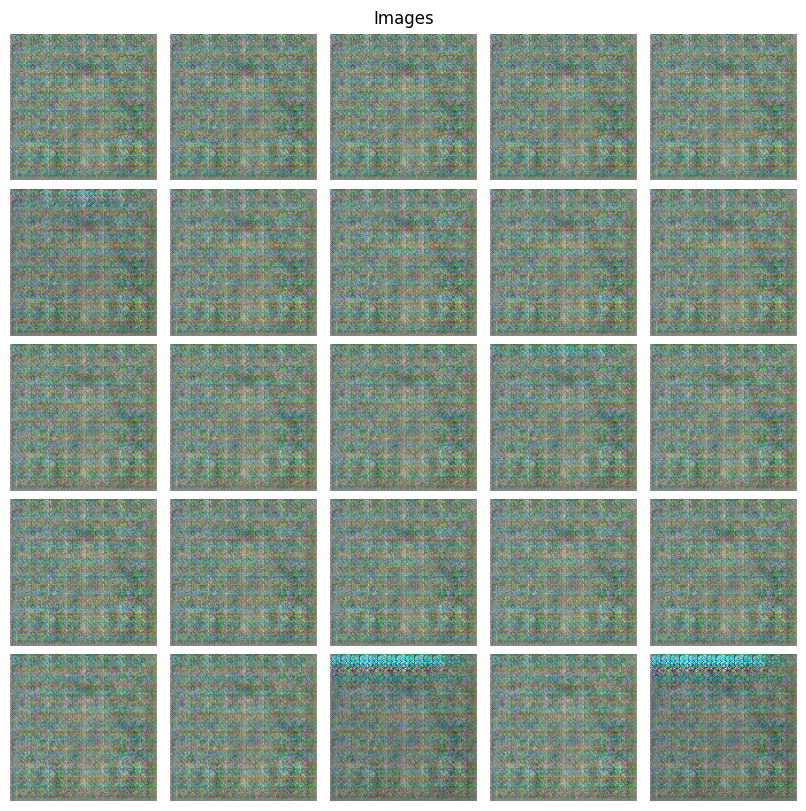

 40%|████      | 4/10 [2:02:44<3:04:07, 1841.24s/it]


KeyboardInterrupt: 

In [10]:
iteration = 0
optimizer = {
    'discriminator': torch.optim.Adam(discriminator.parameters(),  lr=lr, betas=(0.5, 0.999)),
    'generator': torch.optim.Adam(generator.parameters(), lr=lr, betas=(0.5, 0.999))
}
scheduler = {
    'discriminator': StepLR(optimizer['discriminator'], step_size=1, gamma=0.9),
    'generator': StepLR(optimizer['generator'], step_size=1, gamma=0.9)
}

discriminator.train()
generator.train()
for epoch in tqdm(range(epochs)):
    for real_images, _ in dataloader:
        data_size = real_images.size(0)
        real_images = real_images.to(device)
        
        optimizer['discriminator'].zero_grad()
        real_preds = discriminator(real_images)
        real_targets = torch.FloatTensor(data_size, 1).uniform_(*real_label_borders).to(device)
        real_loss = criterion(real_preds, real_targets)

        latent = torch.randn(data_size, latent_dim, 1, 1, device=device)
        fake_images = generator(latent)

        fake_targets = torch.FloatTensor(data_size, 1).uniform_(*fake_label_borders).to(device)
        fake_preds = discriminator(fake_images)
        fake_loss = criterion(fake_preds, fake_targets)

        loss_d = real_loss + fake_loss
        loss_d.backward()
        optimizer['discriminator'].step()


        optimizer['generator'].zero_grad()
        latent = torch.randn(data_size, latent_dim, 1, 1, device=device)
        fake_images = generator(latent)

        preds = discriminator(fake_images)
        targets = torch.ones(data_size, 1, device=device)
        loss_g = criterion(preds, targets)

        loss_g.backward()
        optimizer['generator'].step()
        log.report_scalar('Loss', 'Discriminator', value=loss_d.item(), iteration=iteration)
        log.report_scalar('Loss', 'Generator', value=loss_g.item(), iteration=iteration)
        iteration += 1
        if iteration % 50 == 0:
            clear_output(wait=True)
            show_sample(fake_images.detach().cpu())
        
    scheduler['discriminator'].step()
    scheduler['generator'].step()

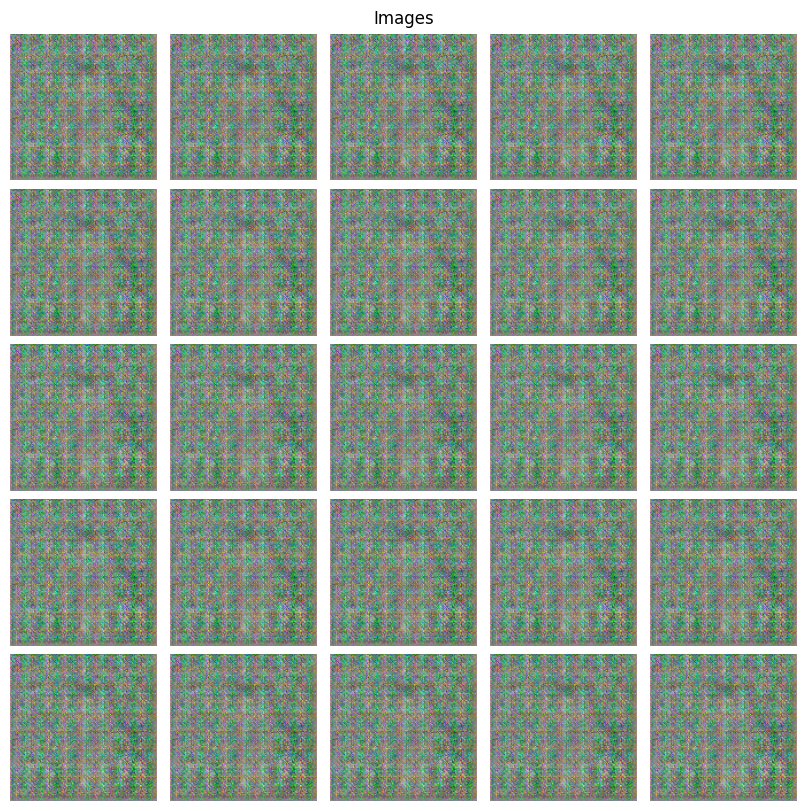

In [11]:
show_sample(fake_images.detach().cpu())

In [12]:
task.close()